In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,Flatten, Reshape, Lambda, Dense, Conv2DTranspose
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import mse

In [2]:
# Define a custom accuracy metric
def accuracy(y_true, y_pred):
    threshold = 0.1
    diff = tf.abs(y_true - y_pred)
    correct = tf.cast(diff < threshold, tf.float32)
    accuracy = tf.reduce_mean(correct)
    return accuracy

In [3]:
# Load MNIST data
(x_train, _), (x_test, _) = mnist.load_data()

In [4]:
# Normalize the images to the range [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [5]:
# Reshape data to fit the network input
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [6]:
# Introduce noise in the dataset
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

In [7]:
# Clip the values to be between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [8]:
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Dense
from tensorflow.keras.models import Model

# Reshape data to fit LSTM input (treat each row as a time step)
x_train_seq = x_train_noisy.reshape((x_train_noisy.shape[0], 28, 28))
x_test_seq = x_test_noisy.reshape((x_test_noisy.shape[0], 28, 28))
x_train_clean_seq = x_train.reshape((x_train.shape[0], 28, 28))
x_test_clean_seq = x_test.reshape((x_test.shape[0], 28, 28))


In [9]:
# Define the LSTM autoencoder model
input_seq = Input(shape=(28, 28))

In [10]:
# Encoder
encoded_seq = LSTM(128, activation='relu', return_sequences=True)(input_seq)
encoded_seq = LSTM(64, activation='relu')(encoded_seq)

In [11]:
# Repeat the encoding
decoded_seq = RepeatVector(28)(encoded_seq)

In [12]:
# Decoder
decoded_seq = LSTM(64, activation='relu', return_sequences=True)(decoded_seq)
decoded_seq = LSTM(128, activation='relu', return_sequences=True)(decoded_seq)
decoded_seq = TimeDistributed(Dense(28))(decoded_seq)

In [13]:
# Build the LSTM autoencoder model
lstm_autoencoder = Model(input_seq, decoded_seq)
lstm_autoencoder.compile(optimizer='adam', loss='mse', metrics=[accuracy])
lstm_autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 lstm (LSTM)                 (None, 28, 128)           80384     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 repeat_vector (RepeatVecto  (None, 28, 64)            0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 28, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 28, 128)           98816     
                                                            

In [14]:
# Function to compute PSNR
def calculate_psnr(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Custom callback to record PSNR values
class PSNRHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.psnr_history = []

    def on_epoch_end(self, epoch, logs=None):
        reconstructions = self.model.predict(x_test_seq)
        psnr_values = [calculate_psnr(x_test_clean_seq[i], reconstructions[i]) for i in range(len(x_test_clean_seq))]
        average_psnr = np.mean(psnr_values)
        self.psnr_history.append(average_psnr)
        logs['psnr'] = average_psnr

psnr_history = PSNRHistory()

In [15]:
# Train the LSTM autoencoder
history=lstm_autoencoder.fit(x_train_seq, x_train_clean_seq,
                     epochs=200,
                     batch_size=256,
                     shuffle=True,
                     validation_data=(x_test_seq, x_test_clean_seq),
                     callbacks=[psnr_history])

Epoch 1/200


235/235 [==============================] - 65s 260ms/step - loss: 0.0667 - accuracy: 0.5958 - val_loss: 0.0561 - val_accuracy: 0.6427 - psnr: 12.8028
Epoch 2/200
235/235 [==============================] - 61s 258ms/step - loss: 0.0482 - accuracy: 0.6788 - val_loss: 0.0409 - val_accuracy: 0.7007 - psnr: 14.2545
Epoch 3/200
235/235 [==============================] - 62s 264ms/step - loss: 0.0371 - accuracy: 0.7191 - val_loss: 0.0342 - val_accuracy: 0.7305 - psnr: 15.0773
Epoch 4/200
235/235 [==============================] - 64s 274ms/step - loss: 0.0319 - accuracy: 0.7409 - val_loss: 0.0294 - val_accuracy: 0.7483 - psnr: 15.7219
Epoch 5/200
235/235 [==============================] - 65s 275ms/step - loss: 0.0287 - accuracy: 0.7548 - val_loss: 0.0273 - val_accuracy: 0.7619 - psnr: 16.0523
Epoch 6/200
235/235 [==============================] - 65s 277ms/step - loss: 0.0263 - accuracy: 0.7665 - val_loss: 0.0255 - val_accuracy: 0.7714 - psnr: 16.3463
Epoch 7/200
235/235 [=====

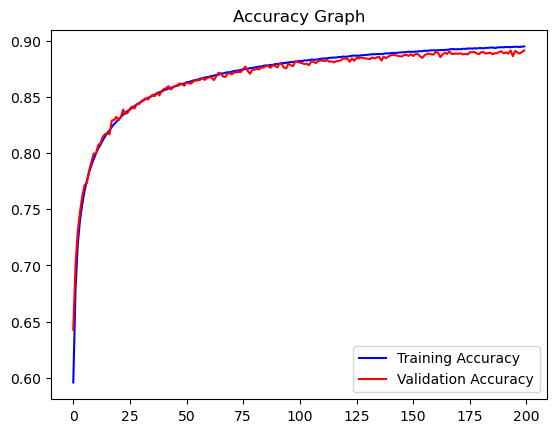

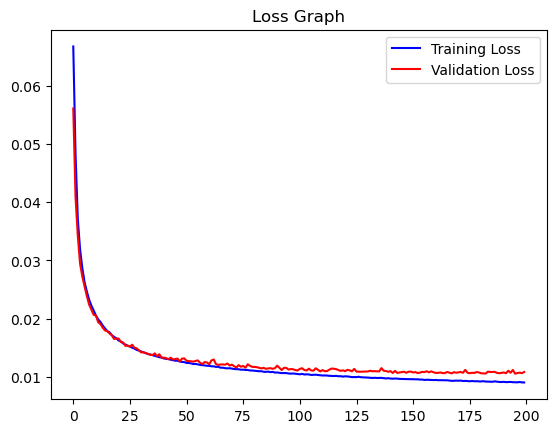

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs,acc, 'b' ,label='Training Accuracy')
plt.plot(epochs,val_acc, 'r',label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs,loss, 'b' ,label='Training Loss')
plt.plot(epochs,val_loss, 'r',label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

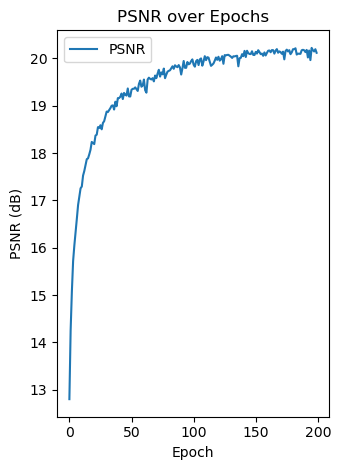

In [17]:
# Plot PSNR values
plt.subplot(1, 2, 2)
plt.plot(psnr_history.model.history.history['psnr'], label='PSNR')
plt.title('PSNR over Epochs')
plt.ylabel('PSNR (dB)')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [18]:
# Predict denoised images
x_test_denoised = lstm_autoencoder.predict(x_test_seq)

313/313 [==============================] - 8s 24ms/step


In [19]:
# Calculate reconstruction error
reconstruction_error = np.mean(np.abs(x_test_clean_seq - x_test_denoised), axis=(1, 2))

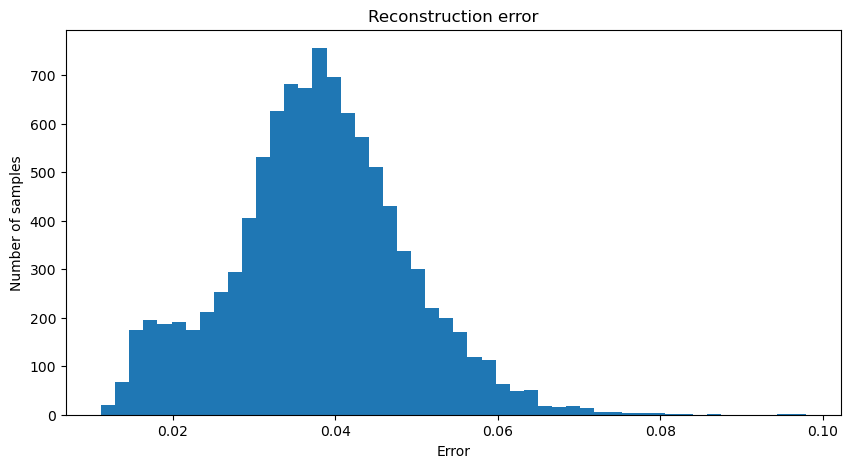

In [20]:
#Plot reconstruction error
plt.figure(figsize=(10, 5))
plt.hist(reconstruction_error, bins=50)
plt.title("Reconstruction error")
plt.xlabel("Error")
plt.ylabel("Number of samples")
plt.show()


In [21]:
# Set a threshold for outliers based on reconstruction error
threshold = np.percentile(reconstruction_error, 95)  # For example, 95th percentile
outliers = reconstruction_error > threshold

In [22]:
# Print the number of outliers detected
print(f"Number of outliers detected: {np.sum(outliers)}")

Number of outliers detected: 500


In [23]:
# Calculate reconstruction error
reconstruction_error = np.mean(np.abs(x_test_clean_seq - x_test_denoised), axis=(1, 2))

# Set a threshold for outliers based on reconstruction error (95th percentile)
threshold = np.percentile(reconstruction_error, 95)


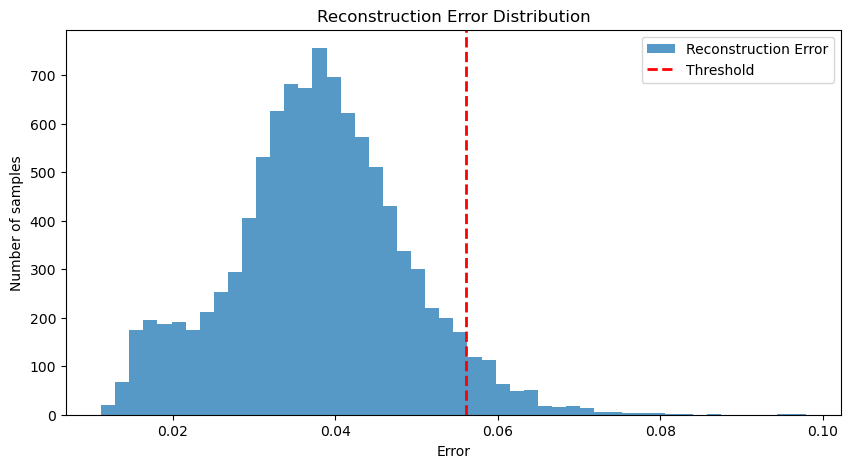

In [24]:
# Plot the reconstruction error distribution
def plot_reconstruction_error(reconstruction_error, threshold):
    plt.figure(figsize=(10, 5))
    plt.hist(reconstruction_error, bins=50, alpha=0.75, label='Reconstruction Error')
    plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2, label='Threshold')
    plt.title('Reconstruction Error Distribution')
    plt.xlabel('Error')
    plt.ylabel('Number of samples')
    plt.legend(loc='upper right')
    plt.show()

plot_reconstruction_error(reconstruction_error, threshold)


In [25]:
# Detect noisy images
reconstructions = lstm_autoencoder.predict(x_test_seq)
mse = np.mean(np.power(x_test_seq - reconstructions, 2), axis=(1, 2))

313/313 [==============================] - 8s 25ms/step


In [26]:
# Calculate PSNR for the test set
psnr_values = [calculate_psnr(x_test_clean_seq[i], reconstructions[i]) for i in range(len(x_test_clean_seq))]
average_psnr = np.mean(psnr_values)
print(f'Average PSNR: {average_psnr:.2f} dB')

Average PSNR: 20.12 dB


In [27]:
# Set a threshold for noisy images
threshold = np.percentile(mse, 95)  # 95th percentile of MSE
noisy_images = mse > threshold

In [28]:
# Filter out noisy images
clean_images = x_test_clean_seq[~noisy_images]

In [29]:
# Function to display a list of images
def plot_images(images, nrows, ncols, cmap='gray'):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i].reshape(28, 28), cmap=cmap)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

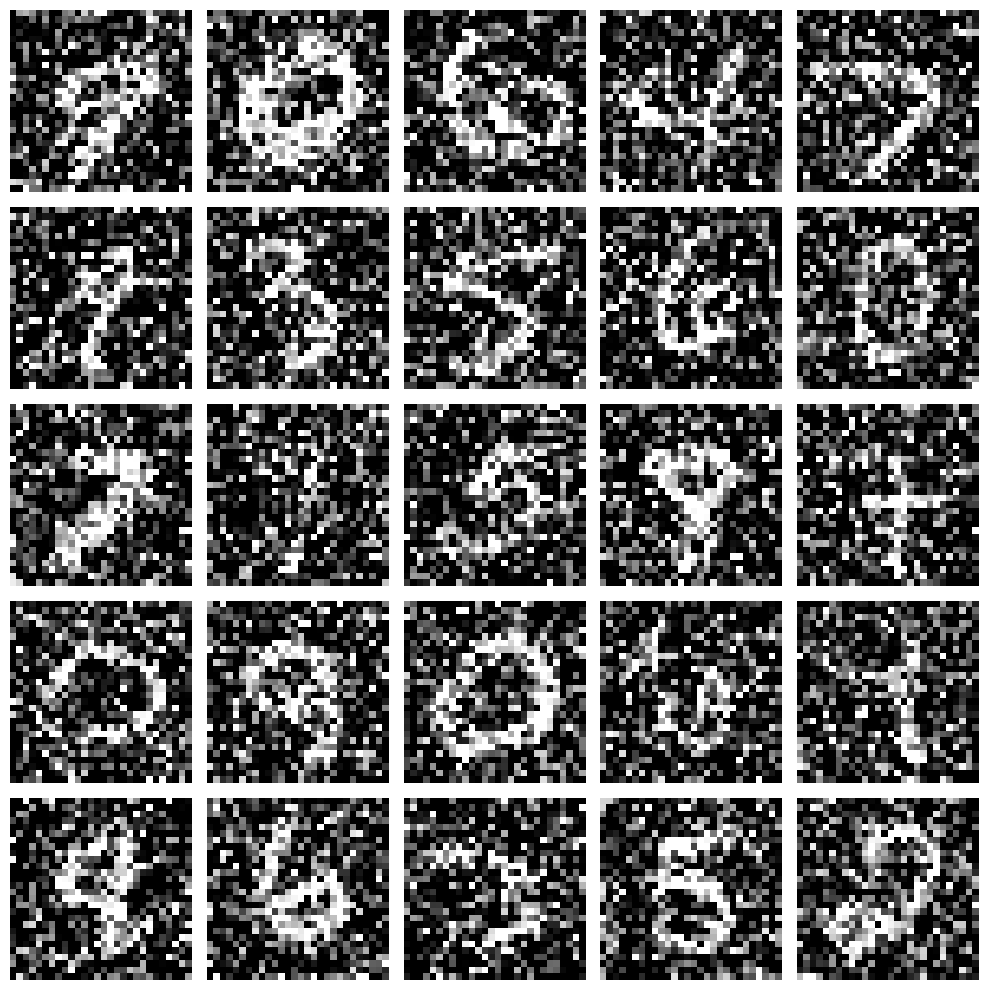

In [30]:
# Display original noisy images
plot_images(x_test_seq[noisy_images][:25], 5, 5)

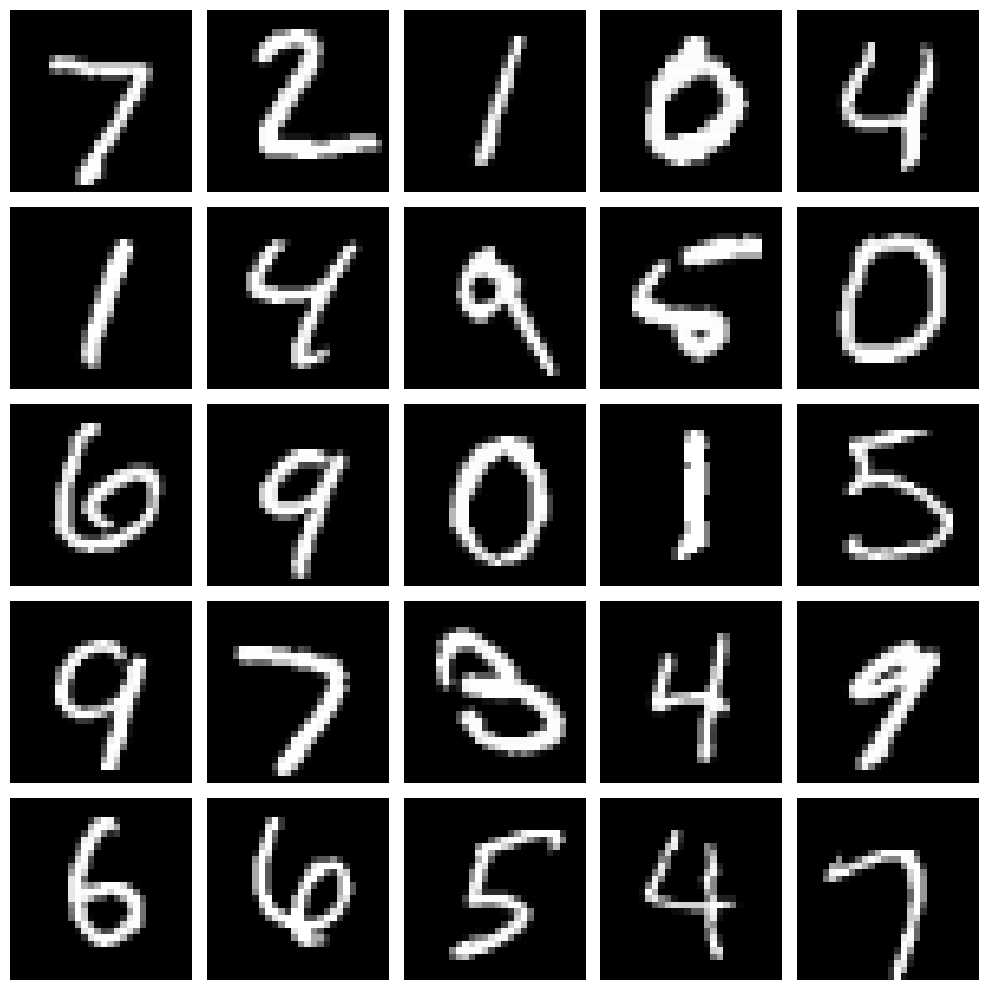

In [31]:
# Display clean images after removing noisy ones
plot_images(clean_images[:25], 5, 5)